This notebook contains the code used in the article 'AI for society: Fake news detection'

Student name: Max Bongers <br>
Student ID: 11349875<br>
E-mail: maxbongers@hotmail.nl<br>
date: 07-02-2021

In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
import nltk, sklearn
import sklearn.metrics
import sklearn.feature_extraction
import sklearn.ensemble
import sklearn.model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

Reading data and dropping duplicate entries

In [2]:
datat = pd.read_csv("true.csv")
dataf = pd.read_csv("fake.csv")

datat['true'] = 1
dataf['true'] = 0

data = pd.concat([datat,dataf]).reset_index(drop = True)

print("Length of database before any cleaning: ",len(data))
data.subject=data.subject.replace({'politicsNews':'politics'})
data = data.drop_duplicates(subset=['text'])
data = data.drop_duplicates(subset=['title'])
print("Length of database after removing duplicates: ",len(data))
data = data.replace(r'^\s*$', np.NaN, regex=True)
data = data.dropna()
print("Length of database after removing empty entries: ",len(data))

Length of database before any cleaning:  44898
Length of database after removing duplicates:  38270
Length of database after removing empty entries:  38268


Plotting wordcloud (can take a while to run)

<Figure size 1440x1440 with 0 Axes>

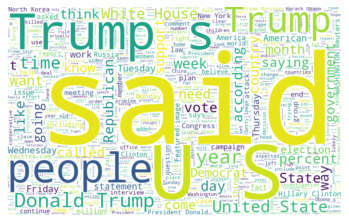

In [3]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, background_color="white", width = 800 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data.text))

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Preprocess data, removing stopwords and lemmatizing all words

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['reuters'])

lemmatizer = WordNetLemmatizer()

# loop through every word, if it's a stopword, remove it from the data
def preprocess(article):
    newword = ""
    for word in gensim.utils.simple_preprocess(article):
        if word not in gensim.parsing.preprocessing.STOPWORDS and len(word) > 2 and word not in stop_words:
            word = lemmatizer.lemmatize(word)
            word = word + " "
            newword = newword + word
            
    return newword

data['text'] = data['text'].apply(preprocess)

Splitting data into training and testing set, then vectorize the data so the algorithm can work with it.

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(data['text'], data['true'], test_size=0.2)

vectorizer = TfidfVectorizer(min_df=0.01,ngram_range=(1,3))
vectorizer.fit(X_train)

train_vectors = vectorizer.transform(X_train)
test_vector = vectorizer.transform(X_test)






Traing classifier and make predictions on the test set

In [6]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
rf.fit(train_vectors, Y_train)
y_pred = rf.predict(test_vector)
y_true = Y_test

Testing accuracy of the algorithm

In [7]:
print("Precision ", average_precision_score(y_true, y_pred))
print("Recall ", recall_score(y_true, y_pred))
print("Accuracy ", accuracy_score(y_true, y_pred))

Precision  0.9558141177063331
Recall  0.9914081145584726
Accuracy  0.972302064280115


Checking feature importances

In [8]:
# Get all the features
importances = rf.feature_importances_
# sort features by importance
indices = np.argsort(importances)[::-1]

feature_names = vectorizer.get_feature_names()
top_words = []

importances = sorted(importances, reverse=True)

# append the top 100 most important features
for i in range(100):
    top_words.append((feature_names[indices[i]], importances[i]))

In [9]:
wordstrue = []
wordsfalse = []
count = 0

# Check which word is important for what classification by checking what the algorithm returns with just that word.
for word in top_words:
    count +=1
    if rf.predict(vectorizer.transform([word[0]])) == [1]:
        wordstrue.append(word)
    else:
        wordsfalse.append(word)

Plot the most important features

Most important features to classify articles as true:

1 ('said', 0.06602307583135486)
2 ('president donald trump', 0.008661716949295024)
3 ('thursday', 0.007838492757802639)
4 ('wednesday', 0.007548278723867018)
5 ('friday', 0.006604533152860551)


Text(0, 0.5, 'Features')

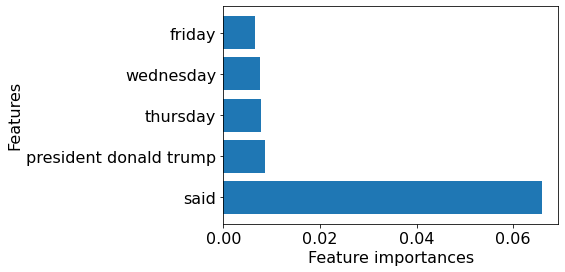

In [10]:
print("Most important features to classify articles as true:")
print("")
count = 0
trues = []
truesnames = []
for x in wordstrue:
    count +=1
    print(count, x)
    trues.append(x[1])
    truesnames.append(x[0])
    if count == 5:
        break
matplotlib.rcParams.update({'font.size': 16})
plt.barh(truesnames,trues)
plt.xlabel("Feature importances")
plt.ylabel("Features")


Text(0, 0.5, 'Features')

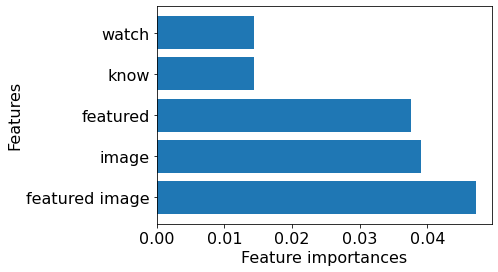

In [11]:
trues = []
truesnames = []
count = 0
for x in wordsfalse:
    count +=1
    trues.append(x[1])
    truesnames.append(x[0])
    if count == 5:
        break
matplotlib.rcParams.update({'font.size': 16})
plt.barh(truesnames,trues)
plt.xlabel("Feature importances")
plt.ylabel("Features")


Plotting confusion matrix, this code is almost entirely copied from matplotlibs website:
https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

In [12]:
confusion_matrix(y_true, y_pred)

array([[3288,  176],
       [  36, 4154]], dtype=int64)

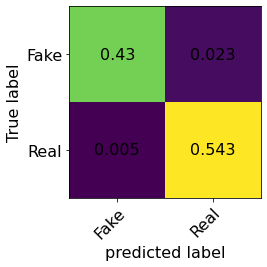

In [13]:
X = ["Fake","Real"]
Y = ["Fake","Real"]

harvest = confusion_matrix(y_true, y_pred)
harvest = harvest / np.sum(harvest)

round_to_tenths = [round(num, 3) for num in harvest[0]]
round_to_tenths1 = [round(num, 3) for num in harvest[1]]
numbers = [round_to_tenths, round_to_tenths1]
harvest = np.asarray(numbers)

fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(Y)))
ax.set_yticks(np.arange(len(X)))
# ... and label them with the respective list entries
ax.set_xticklabels(Y)
ax.set_yticklabels(X)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(X)):
    for j in range(len(Y)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="black")
plt.xlim(-0.5, len(np.unique(y_true))-0.5)
plt.ylim(len(np.unique(y_true))-0.5, -0.5)

plt.ylabel("True label")
plt.xlabel("predicted label")
fig.tight_layout()
plt.show()
